# Run level 2A, 2B and 3 pipelines on MRS data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) April 10th 2018

This notebook demonstrates the execution of the level 2A, 2B, and 3 pipelines for MRS data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The files used in this notebook is a MIRISim simulation of a point source with power-law (alpha=0) plus emission lines spectrum. The simulated observation is a four-point dither on the source with the channels 1 and 2, and the SHORT disperser. 

The steps applied are:

- ramps to slopes pipeline (Detector1Pipeline)

- CALSPEC2 steps and spectral extraction from each dither (Spec2Pipeline)

- combination of dithers and spectral extraction (Spec3Pipeline)

- manual conversion of extracted spectra to Jy 


#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input, output location and source type
Since we know the simulation is of a point source, we can set the source type metadata to 'POINT' at this stage as that information is used later in spectral extraction. Otherwise, the pipeline will set the default source type for MRS which is 'EXTENDED'

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'MRS_demo_data'
input_dir = 'MRS_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the source type as 'POINT'
for f in input_files:
    with datamodels.MIRIRampModel(f) as dm:
        dm.meta.target.source_type = 'POINT'
        dm.save(os.path.join(input_dir, dm.meta.filename))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFUSHORT	 2	 50	 FAST	 12	 SHORT



Filename: MRS_demo_data/det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   ()      
  1  SCI           1 ImageHDU        62   (1032, 1024, 50, 2)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 50, 2)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 50, 2)   float32   
  5  REFOUT        1 ImageHDU        12   (258, 1024, 50, 2)   float32   
  6  PIXELDQ_DEF    1 BinTableHDU     17   31R x 4C   [J, J, 40A, 128A]   
  7  ASDF          1 AsdfHDU          8   (105680587,)      


#### show the last frame of the first integration for each file

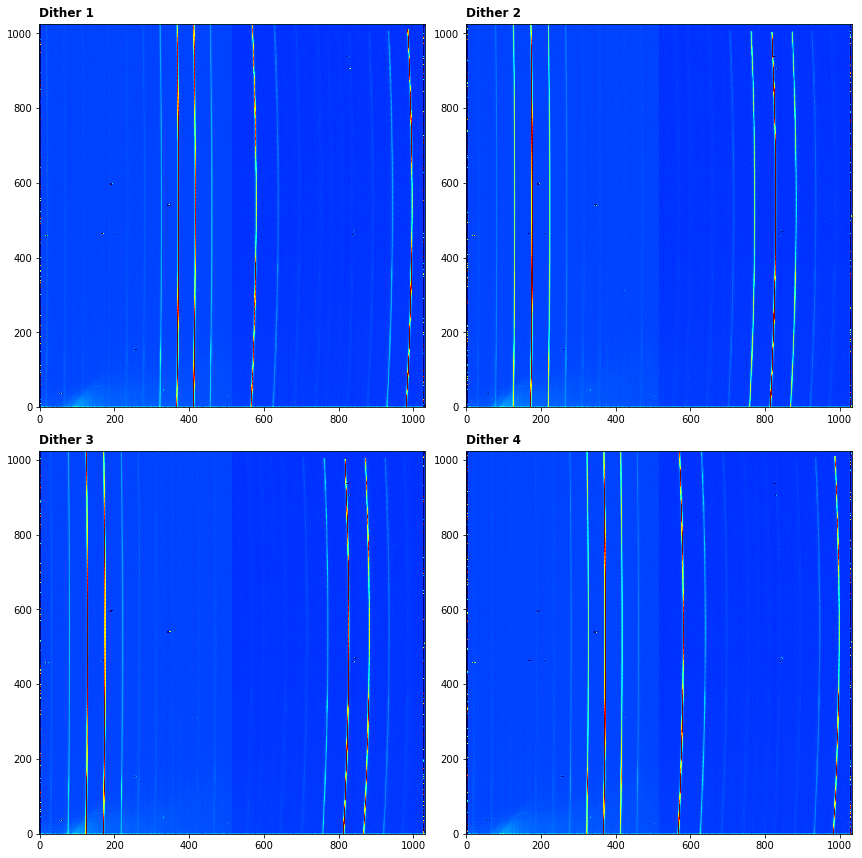

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for f in input_files:
    # open the input image as a jwst data model
    with datamodels.MIRIRampModel(f) as in_dm:

        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)



    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.

    


#### run pipeline
We pass the level 1B files (demo data). We need to explicitly skip the IPC step. The output level 2A files will be saved in the output_dir as '*_rate.fits'


In [6]:
for f in input_files:
    Detector1Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True}})


2018-04-17 11:37:35,617 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2018-04-17 11:37:35,620 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2018-04-17 11:37:35,622 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2018-04-17 11:37:35,624 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2018-04-17 11:37:35,626 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2018-04-17 11:37:35,628 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2018-04-17 11:37:35,630 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2018-04-17 11:37:35,632 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2018-04-17 11:37:35,633 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2018-04-17 11:37:35,635 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance crea

2018-04-17 11:39:19,115 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<jwst.datamodels.ramp.RampModel object at 0x1818a608d0>,).
2018-04-17 11:39:19,161 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2018-04-17 11:39:19,173 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2018-04-17 11:39:19,246 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2018-04-17 11:39:21,110 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2018-04-17 11:39:21,775 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2018-04-17 11:39:25,109 - stpipe.Detector1Pipeline.jump - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/jump/twopoi

2018-04-17 11:44:47,748 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2018-04-17 11:44:47,749 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2018-04-17 11:44:48,349 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0056.fits'.
2018-04-17 11:44:48,350 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2018-04-17 11:44:48,351 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits'.
2018-04-17 11:44:48,352 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0020.fits'.
2018-04-17 11:44:48,353 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT referen

2018-04-17 11:46:37,322 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2018-04-17 11:46:37,465 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2018-04-17 11:46:37,503 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols
2018-04-17 11:46:37,504 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal
2018-04-17 11:46:37,510 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all final reads flagged as DO_NOT_USE.
2018-04-17 11:46:37,535 - stpipe.Detector1Pipeline.ramp_fit - INFO - Effective integration time per group: 2.77504
2018-04-17 11:48:20,623 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils

2018-04-17 11:51:31,424 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0020.fits'.
2018-04-17 11:51:31,425 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2018-04-17 11:51:31,426 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2018-04-17 11:51:31,426 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2018-04-17 11:51:31,427 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('MRS_demo_data/det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits',).
2018-04-17 11:51:31,428 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2018-04-17 11:51:31,841 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<jwst.datamodels.ramp.RampModel object at 0x1135290f0>,).
2018-04-17 11:51:31,881 - stpipe.Detector1Pipeline.group_scal

2018-04-17 11:55:25,034 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:481: RuntimeWarning: divide by zero encountered in true_divide
  var_r = rn_1d**2 * 12./(segments**3. - segments)

2018-04-17 11:55:25,707 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:485: RuntimeWarning: divide by zero encountered in true_divide
  sum_r = (segments*var_r[:]/((nsegs_pix)**3.)).sum(axis=0)

2018-04-17 11:55:25,709 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:485: RuntimeWarning: invalid value encountered in true_divide
  sum_r = (segments*var_r[:]/((nsegs_pix)**3.)).sum(axis=

2018-04-17 11:58:37,945 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0020.fits
2018-04-17 11:58:40,908 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2018-04-17 11:58:41,017 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<jwst.datamodels.ramp.RampModel object at 0x1818c19b38>,).
2018-04-17 11:58:41,056 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0020.fits
2018-04-17 11:58:42,395 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done
2018-04-17 11:58:42,474 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<jwst.datamodels.ramp.RampModel object at 0x1818d2f978>,).
2018-04-17 11:58:42,475 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.
2018-04-17 11:58:42,478 - stpipe.Detector1Pipeline.ipc - INFO -

2018-04-17 12:05:23,678 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/patrickkavanagh/anaconda/envs/jwst0.9.2/lib/python3.5/site-packages/jwst-0.9.2-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:620: RuntimeWarning: invalid value encountered in sqrt
  cubemod.err = np.sqrt(var_p_int + var_r_int)

2018-04-17 12:05:23,716 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 50
2018-04-17 12:05:23,717 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2
2018-04-17 12:05:24,175 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2018-04-17 12:05:24,373 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<jwst.datamodels.ifuimage.IFUImageModel object at 0x11362fa20>,).
2018-04-17 12:05:24,450 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2018-04-17 12:05:24,450 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2018-04-17 12:05:

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('firstframe: %s' % dm.meta.cal_step.firstframe)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: None
linearity: COMPLETE
rscd: COMPLETE
firstframe: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. 

Note that since MIRISim does not add straylight, we can skip the straylight correction step.

In [9]:
for f in level2A_files:
    Spec2Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir, 
                       steps={'straylight':{'skip':True}})


2018-04-17 12:05:25,226 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2018-04-17 12:05:25,229 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2018-04-17 12:05:25,230 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2018-04-17 12:05:25,232 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2018-04-17 12:05:25,234 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2018-04-17 12:05:25,236 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2018-04-17 12:05:25,237 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2018-04-17 12:05:25,239 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2018-04-17 12:05:25,242 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2018-04-17 12:05:25,245 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2018-04-17 

2018-04-17 12:05:41,336 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2018-04-17 12:05:41,337 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2018-04-17 12:05:42,396 - stpipe.Spec2Pipeline.fringe - INFO - The DQ values in the reference file will NOT be used to update the    DQ values in the output DQ array.
2018-04-17 12:05:42,400 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done
2018-04-17 12:05:42,562 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<jwst.datamodels.ifuimage.IFUImageModel object at 0x11381be48>,).
2018-04-17 12:05:42,624 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0020.fits
2018-04-17 12:05:42,630 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2018-04-

2018-04-17 12:08:04,757 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2018-04-17 12:08:04,758 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2018-04-17 12:08:04,759 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0002.fits'.
2018-04-17 12:08:04,760 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2018-04-17 12:08:04,764 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2018-04-17 12:08:04,765 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0021.asdf'.
2018-04-17 12:08:04,766 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2018-04-17 12:08:04,767 - stpipe.Spe

2018-04-17 12:08:24,086 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2018-04-17 12:08:24,087 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: ra-dec
2018-04-17 12:08:24,089 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: msm
2018-04-17 12:08:24,089 - stpipe.Spec2Pipeline.cube_build - INFO - Power Weighting distance : 2.000000
2018-04-17 12:08:24,160 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes covers the MIRI Channels: ['1', '2']
2018-04-17 12:08:24,162 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes covers the MIRI subchannels: ['SHORT', 'SHORT']
2018-04-17 12:08:24,164 - stpipe.Spec2Pipeline.cube_build - INFO - Reading  cube parameter file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0002.fits
2018-04-17 12:08:27,787 - stpipe.Spec2Pipeline.cube_build - INFO - Output IFUcube are constructed from all the data 
2018-04-17 12:08:27,789 - stpipe.Spec2Pip

2018-04-17 12:10:52,915 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2018-04-17 12:10:52,916 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2018-04-17 12:10:52,917 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2018-04-17 12:10:52,917 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2018-04-17 12:10:52,919 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.
2018-04-17 12:10:52,920 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2018-04-17 12:10:52,920 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.
2018-04-17 12:10:52,921 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0020.fits'.
2018-04-17 12:10:52,922 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/Users/patrickk

2018-04-17 12:11:16,111 - stpipe.Spec2Pipeline.cube_build - INFO - Ra average -0.00034912.8
2018-04-17 12:11:16,115 - stpipe.Spec2Pipeline.cube_build - INFO - Cube Geometry:
2018-04-17 12:11:16,115 - stpipe.Spec2Pipeline.cube_build - INFO - axis# Naxis  CRPIX    CRVAL      CDELT(arc sec)  MIN & Max (xi,eta arc sec)
2018-04-17 12:11:16,116 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 1    42  22.00  -0.00034857   0.13000000  -2.79499990   2.79499990
2018-04-17 12:11:16,117 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 2    40  21.00  -0.00019485   0.13000000  -2.66499990   2.66499990
2018-04-17 12:11:16,118 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 3  4029   1.00   4.84778546   0.00100000   4.84778546   8.87678565
2018-04-17 12:11:16,119 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1 SHORT 
2018-04-17 12:11:16,119 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2 SHORT 
2018-04-17 12:11:16,120 - stpipe.Spec2Pipeline.c

2018-04-17 12:13:37,134 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('MRS_demo_data_pipelined/det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits',).
2018-04-17 12:13:37,134 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...
2018-04-17 12:13:37,406 - stpipe.Spec2Pipeline - INFO - Processing product MRS_demo_data_pipelined/det_image_seq3_MIRIFUSHORT_12SHORTexp1
2018-04-17 12:13:37,408 - stpipe.Spec2Pipeline - INFO - Working on input MRS_demo_data_pipelined/det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits ...
2018-04-17 12:13:37,988 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<jwst.datamodels.ifuimage.IFUImageModel object at 0x181ec94048>,).
2018-04-17 12:13:51,162 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs did not update S_REGION for type MIR_MRS
2018-04-17 12:13:51,163 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2018-04-17 12:13:51,176 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wc

2018-04-17 12:16:03,708 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2018-04-17 12:16:03,825 - stpipe.Spec2Pipeline.extract_1d - INFO - source_type = point
2018-04-17 12:16:15,135 - stpipe.Spec2Pipeline.extract_1d - INFO - Data have been flux calibrated; setting net to 0.
2018-04-17 12:16:15,392 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2018-04-17 12:16:15,393 - stpipe.Spec2Pipeline - INFO - Finished processing product MRS_demo_data_pipelined/det_image_seq3_MIRIFUSHORT_12SHORTexp1
2018-04-17 12:16:16,910 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_demo_data_pipelined/det_image_seq3_MIRIFUSHORT_12SHORTexp1_cal.fits
2018-04-17 12:16:17,315 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2018-04-17 12:16:17,316 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


### check of output

The level 2B pipeline for the MRS produces three files for each input:

_cal.fits - the calibrated level 2B file from each dither

_s3d.fits - the cube from each dither

_x1d.fits - the 1d spectrum from each dither


In [10]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
cube_files = glob.glob(os.path.join(output_dir,'*_s3d.fits'))

#### level 2B file

In [11]:
with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('straylight: %s' % dm.meta.cal_step.straylight)
    print('fringe: %s' % dm.meta.cal_step.fringe)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
straylight: None
fringe: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

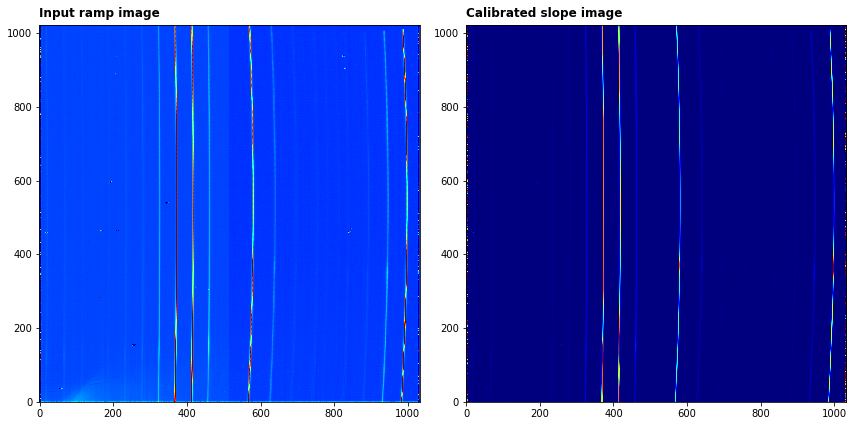

In [12]:
# open the input image as a jwst data model
with datamodels.MIRIRampModel(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0, vmax=500)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

#### Look at cube file. We'll look at the first dither only

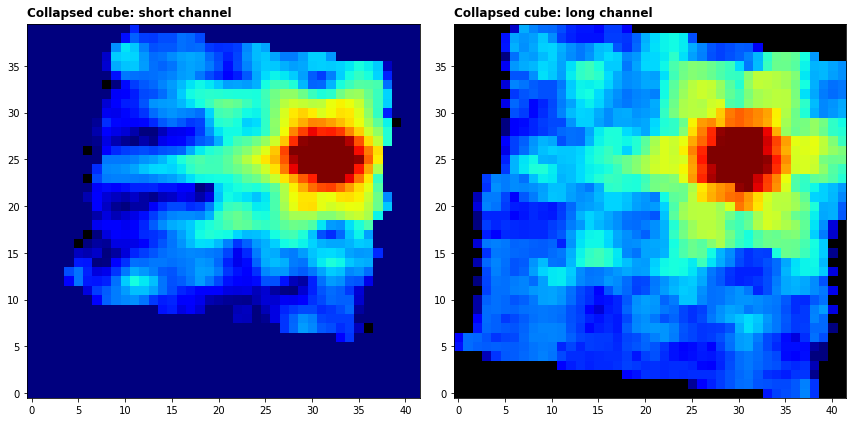

In [13]:
# open the cube as a jwst data model
with datamodels.open(cube_files[0]) as cube_dm:
    
    # plot--------------------------------------
    # sum some of the the frames in each channel
    # Note the user may have to adjust the scaling
    # parameters
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=1e4))
    axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(np.sum(cube_dm.data[3000:3200], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=1e4))
    axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

### Level 3 pipeline

The Spec3Pipeline is not quite working in jwst-0.9.2. 

For now, we just use the cube_build and extract_1d steps to produce level 3 cube and spectral products.

We first create an association file in the output directory containing the list of level 2B files ("_cal.fits") produced by the level 2B pipeline. 

#### create the level 3 association using the asn_from_list tool

In [14]:
call(["asn_from_list", "-o", "MRS_asn.json"] + level2B_files + ["--product-name", "dither"])


0

In [15]:
from jwst.extract_1d import extract_1d_step
from jwst.cube_build import cube_build_step

dms = datamodels.open("MRS_asn.json")
cube_dms = cube_build_step.CubeBuildStep.call(dms, save_results=True, output_dir=output_dir)
spec_dms = extract_1d_step.Extract1dStep.call(cube_dms, output_use_model=True, save_results=True, 
                                              output_dir=output_dir)


2018-04-17 12:16:37,094 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2018-04-17 12:16:37,565 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args (<jwst.datamodels.container.ModelContainer object at 0x1820430278>,).
2018-04-17 12:16:37,566 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2018-04-17 12:16:37,567 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2018-04-17 12:16:37,568 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2018-04-17 12:16:37,568 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2018-04-17 12:16:37,569 - stpipe.CubeBuildStep - INFO - Power Weighting distance : 2.000000
2018-04-17 12:17:09,584 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI Channels: ['1', '2']
2018-04-17 12:17:09,585 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI subchannels: ['SHORT', 'SHORT']
2018-04-17 12:17:09,586 - stpipe.CubeBuildStep - INFO - Reading  

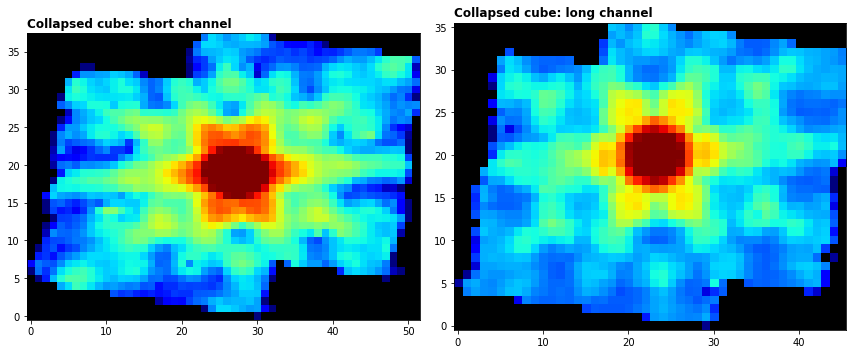

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(cube_dms[0].data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=20,vmax=1e4))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(cube_dms[1].data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=20,vmax=1e4))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()



Note that since we have set the source type to 'POINT' above, the extract_1d step will use an aperture extraction and subtract a background with default values. The aperture centre is at pixel x/2, y/2, the radius is y/4, and the background annulus is from the radius to the radius*sqrt(2). In the future, more advanced extraction methods are planned. One can set also the aperture properties using a custom aperture reference file. Please contact pkavanagh@cp.dias.ie if you want to do this.

The extracted spectra are in units of mJy/arcsec^2. To convert these to mJy we multiply by the spaxel area. Note that an additional aperture correction factor for the encircled energy in the aperture should also be applied but we forego this here since the CDPs are currently not available.

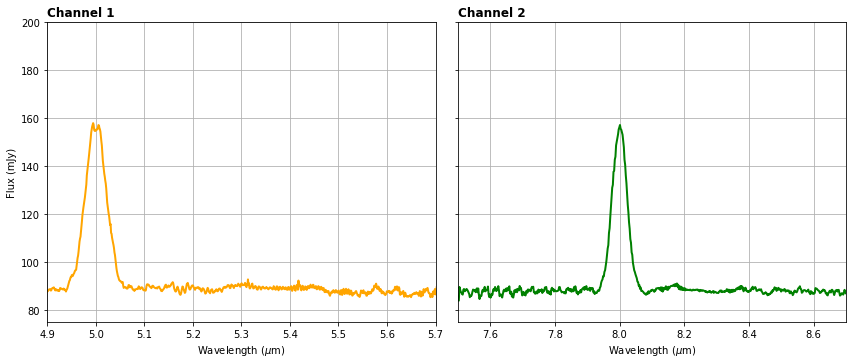

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot the spectrum in the channel 2 wavelength range
spaxel_area = cube_dms[0].meta.wcsinfo.cdelt1 * cube_dms[0].meta.wcsinfo.cdelt2 * 3600**2
axs[0].plot(spec_dms[0].spec[0].spec_table['WAVELENGTH'], spec_dms[0].spec[0].spec_table['FLUX'] * spaxel_area, c='orange', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux (mJy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
axs[0].set_xlim(4.9,5.7)
axs[0].set_ylim(75,200)
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].grid()
spaxel_area = cube_dms[1].meta.wcsinfo.cdelt1 * cube_dms[1].meta.wcsinfo.cdelt2 * 3600**2
axs[1].plot(spec_dms[1].spec[0].spec_table['WAVELENGTH'], spec_dms[1].spec[0].spec_table['FLUX']  * spaxel_area, c='g', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
axs[1].set_xlim(7.5,8.7)
axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].grid()

plt.tight_layout()
plt.show()